## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
vars_num = data.select_dtypes(include=['float', 'int']).columns

vars_cat = data.select_dtypes(include=['object']).columns

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


### Find missing values in variables

In [16]:
# first in numerical variables

# Finding out which are the categorical variables
print(data.select_dtypes(include=['object']).columns)

# dropping those columns to form another dataframe which contains only numerical variables
data_num = data.drop(['sex', 'cabin', 'embarked', 'title'], axis=1)

print("missing values", data_num.isnull().sum())

Index(['sex', 'cabin', 'embarked', 'title'], dtype='object')
missing values pclass        0
survived      0
age         263
sibsp         0
parch         0
fare          1
dtype: int64


In [21]:
# now in categorical variables

print(data.select_dtypes(include=['float', 'int']).columns)
data_cat = data.drop(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare'], axis=1)
print(data_cat.isnull().sum())

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare'], dtype='object')
sex            0
cabin       1014
embarked       2
title          0
dtype: int64


### Determine cardinality of categorical variables

In [22]:
categorical_vars = data_cat.columns
for var in categorical_vars:
    cardinality = data_cat[var].nunique()
    print(f'{var} has cardinality {cardinality}')

sex has cardinality 2
cabin has cardinality 181
embarked has cardinality 3
title has cardinality 5


### Determine the distribution of numerical variables

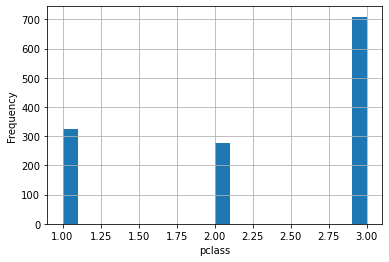

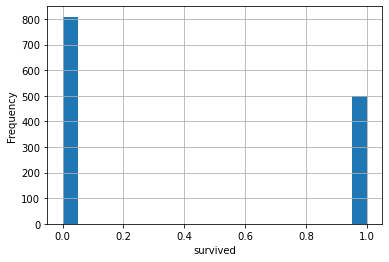

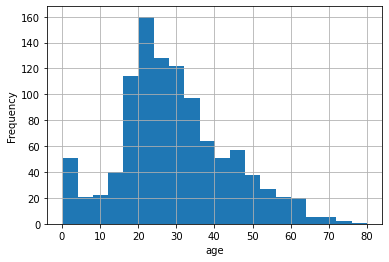

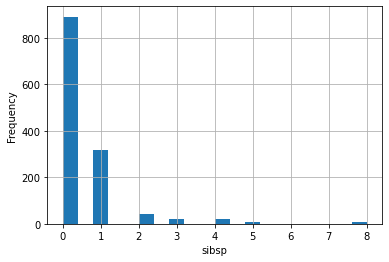

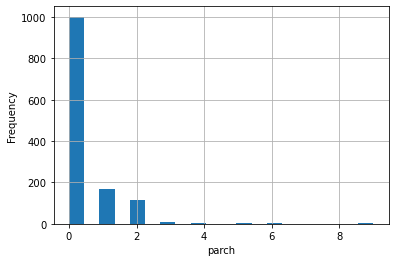

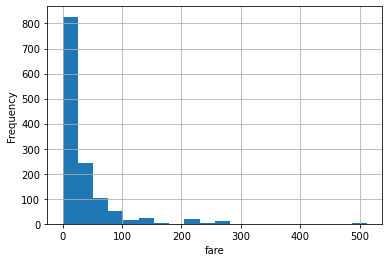

In [23]:
num_vars = data_num.columns
for var in num_vars:
    data_num[var].hist(bins=20)
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

In [31]:
X_train

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,sex_na,cabin_na,embarked_na,title_na,pclass_na,age_na,sibsp_na,parch_na,fare_na
1118,3,male,25.0000,0,0,7.9250,C,S,Mr,0,1,0,0,0,0,0,0,0
44,1,female,41.0000,0,0,134.5000,E,C,Miss,0,0,0,0,0,0,0,0,0
1072,3,male,24.0000,0,0,7.7333,C,Q,Mr,0,1,0,0,0,1,0,0,0
1130,3,female,18.0000,0,0,7.7750,C,S,Miss,0,1,0,0,0,0,0,0,0
574,2,male,29.0000,1,0,21.0000,C,S,Mr,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,3,female,0.1667,1,2,20.5750,C,S,Miss,0,1,0,0,0,0,0,0,0
835,3,male,24.0000,0,0,8.0500,C,S,Mr,0,1,0,0,0,1,0,0,0
1216,3,female,24.0000,0,0,7.7333,C,Q,Miss,0,1,0,0,0,1,0,0,0
559,2,female,20.0000,0,0,36.7500,C,S,Miss,0,1,0,0,0,0,0,0,0


## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [26]:
X_train['cabin'] = np.where(X_train['cabin'].notnull(),X_train['cabin'].astype(np.str).str[0],np.nan)
X_train['cabin'].value_counts()

X_test['cabin'] = np.where(X_test['cabin'].notnull(),X_test['cabin'].astype(np.str).str[0],np.nan)
X_test['cabin'].value_counts()

C:\Users\btnan\AppData\Local\Temp\ipykernel_58596\2881305780.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train['cabin'] = np.where(X_train['cabin'].notnull(),X_train['cabin'].astype(np.str).str[0],np.nan)
C:\Users\btnan\AppData\Local\Temp\ipykernel_58596\2881305780.py:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test['cabin'] = np.where(X_t

C    16
B    13
D    10
E     5
A     3
F     3
G     1
Name: cabin, dtype: int64

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [40]:
num_missing = [var for var in vars_num if data[var].isnull().sum()>0]
for var in num_missing:

    
    mode = X_train[var].mode()[0]    
    X_train['{}_na'.format(var)] = pd.isna(X_train[var]).astype(int)
    X_test['{}_na'.format(var)] = pd.isna(X_test[var]).astype(int)
    X_train[var].fillna(value=mode, inplace=True)
    X_test[var].fillna(value=mode, inplace=True)

X_train[num_missing].isnull().sum() 

age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [41]:
cat_missing = [var for var in vars_cat if data[var].isnull().sum()>0]

X_train[cat_missing] = X_train[cat_missing].fillna('Missing')
X_test[cat_missing] = X_test[cat_missing].fillna('Missing')
X_train[cat_missing].isnull().sum()

cabin       0
embarked    0
dtype: int64

In [42]:
X_test[cat_missing].isnull().sum()

cabin       0
embarked    0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [43]:
def find_frequent_labels(df, var, rare_perc, target):
    df = df.copy()
    rare_qty = int(df.shape[0] * rare_perc)
    freq_labels = df[var].value_counts()[df[var].value_counts() > rare_qty].index
    return df.loc[df[var].isin(freq_labels), var]

In [44]:
for var in categorical_vars:
    frequent_labels = find_frequent_labels(X_train, var, 0.05, target)
    X_train[var] = np.where(X_train[var].isin(frequent_labels), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(frequent_labels), X_test[var], 'Rare')

In [45]:
X_train['cabin'].value_counts()

C       881
Rare    166
Name: cabin, dtype: int64

In [46]:
X_test['cabin'].value_counts()

C       227
Rare     35
Name: cabin, dtype: int64

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [48]:
X_train[categorical_vars].isnull().sum()

sex         0
cabin       0
embarked    0
title       0
dtype: int64

In [49]:
X_train[categorical_vars].nunique()

sex         2
cabin       2
embarked    3
title       4
dtype: int64

In [50]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

ct = ColumnTransformer(transformers=[('OHEncode',OneHotEncoder(drop='first'), categorical_vars)],remainder='passthrough')
X_train = np.array(ct.fit_transform(X_train))
X_test = np.array(ct.transform(X_test))

In [51]:
X_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

### Scale the variables

- Use the standard scaler from Scikit-learn

In [52]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [53]:
log_reg = LogisticRegression(penalty='l1', tol=0.0005, random_state=0, solver='liblinear', l1_ratio=1)
log_reg.fit(X_train, y_train)

C:\Users\Public\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


LogisticRegression(l1_ratio=1, penalty='l1', random_state=0, solver='liblinear',
                   tol=0.0005)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [55]:
y_pred = log_reg.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test.values, y_pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test.values, y_pred):.3f}")

Accuracy: 0.802
ROC-AUC: 0.778


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**